# Demo: Backtesting Quantitative Trading Algorithms

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import talib                    # TA-lib => Technical Analysis library (indicators)
from abc import ABC             # ABC => abstract base class

### Load 1Y of BTC and ETH Data

In [2]:
def clean_price(p):
    return float(p.replace(',',''))

def read_bars(barpath):
    df = pd.read_csv(barpath)
    df['Date'] = pd.to_datetime(df['Date'])
    for col in ['Open', 'High', 'Low', 'Close']:
        df[col] = df[col].apply(clean_price)
    df = df.sort_values('Date').reset_index(drop=True)
    return df

In [3]:
df_btc = read_bars("data/BTCUSD_daily_bars.csv")
df_eth = read_bars("data/ETHUSD_daily_bars.csv")

In [4]:
df_btc.head()

,Date,Open,High,Low,Close
0,2020-07-14,9256.0,9278.0,9135.0,9272.0
1,2020-07-15,9272.0,9277.0,9170.0,9216.0
2,2020-07-16,9216.0,9231.0,9051.0,9103.0
3,2020-07-17,9104.0,9185.0,8608.0,9159.0
4,2020-07-18,9159.0,9208.0,9131.0,9185.0


## Define Trading Algorithm(s)

In [5]:
class tradingAlgo(ABC):
    """
    Abstract base class defining trading algorithm methods
    """
    
    def __init__(self):
        """
        Initialize algorithms by specifying hyperparameters
        """
        pass
    
    def handle_data(self, data):
        """
        Called every time a bar of data is pushed from the backtesting
        or live trading API
        """
        pass

In [6]:
class dualMovingAverageCrossover(tradingAlgo):
    """
    Dual Moving Average Crossover trading algorithm 
    
    Handles only 1 price ticker. Utilizes a short term simple
    moving average and a long term simple moving average to 
    define bullish/bearish trend.
    """
    
    def __init__(self, short_lookback, long_lookback, time_of_bar='Close'):
        """
        Initialize an instance of class dualMovingAverageCrossover
        by specifying algorithm hyperparameters
        
        Parameters
        ----------
        short_lookback : int
            Number of bars to lookback for short term moving average
            
        long_lookback : int
            Number of bars to lookback for long term moving average
            
        time_of_bar : str from ['Open', 'High', 'Low', 'Close']
            Time of OHCL bar data to use for indicators
        """
        
        self._short_lookback = short_lookback
        self._long_lookback = long_lookback
        self._time_of_bar = time_of_bar
    
    def handle_data(self, data):
        """
        Called every time a bar of data is pushed from the backtesting
        or live trading API
        
        Parameters
        ----------
        data : pd.DataFrame
            OHCL price bars for the asset(s) of choice
        """
        
        px = data[self._time_of_bar].values
        if len(px) < self._long_lookback + 1:
            return 0
        signal = self._generate_signal(px)
        target = signal * 1.0
        return target
    
    def _generate_signal(self, px):
        """
        Generate trading signal given price data
        """
        
        sma = px[-self._short_lookback:].mean()
        lma = px[-self._long_lookback:].mean()
        if sma > lma:
            return 1
        else:
            return 0

## Backtest Algorithm(s)

In [7]:
def run_backtest(df, algo, initial_val=10000, time_of_bar='Close'):
    """
    Execute a backtest with historical data and an algorithm
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with columns ['Date', 'Open', 'High', 'Close', 'Low']
        It is expected that the dataframe is sorted by 'Date' in inceasing order
        
    algo : tradingAlgo
        Trading algorithm to backtest
    """
    
    # Initialize data structures
    n_shares = [0.0]
    asset_val = [0.0]
    cash_val = [initial_val]
    portfolio_val = [asset_val[-1] + cash_val[-1]]
    dates = [df.Date[0]]
    
    # Iterate through OHCL bars of data
    for i in range(1, len(df)):

        price = df.iloc[i][time_of_bar]
        
        # Find target allocation from algorithm
        target = algo.handle_data(df.iloc[:i])
        
        # Take on target position, record result
        if target == 0:
            cash_val.append((n_shares[-1]*price) + cash_val[-1])
            n_shares.append(0.0)
        elif target == 1:
            n_shares.append(n_shares[-1] + (cash_val[-1]/price))
            cash_val.append(0.0)
        else:
            raise ValueError("Target between (0,1) not supported yet!")
        
        asset_val.append(n_shares[-1] * price)
        portfolio_val.append(asset_val[-1] + cash_val[-1])
        dates.append(df.Date[i])
        
    return pd.DataFrame({'Date':dates, 'Cash Value':cash_val, 
                         'Asset Shares':n_shares, 'Asset Value':asset_val, 
                         'Portfolio Value':portfolio_val})

In [8]:
dma_crossover = dualMovingAverageCrossover(20, 50)
result = run_backtest(df_btc, dma_crossover)

In [9]:
result.head()

,Date,Cash Value,Asset Shares,Asset Value,Portfolio Value
0,2020-07-14,10000.0,0.0,0.0,10000.0
1,2020-07-15,10000.0,0.0,0.0,10000.0
2,2020-07-16,10000.0,0.0,0.0,10000.0
3,2020-07-17,10000.0,0.0,0.0,10000.0
4,2020-07-18,10000.0,0.0,0.0,10000.0


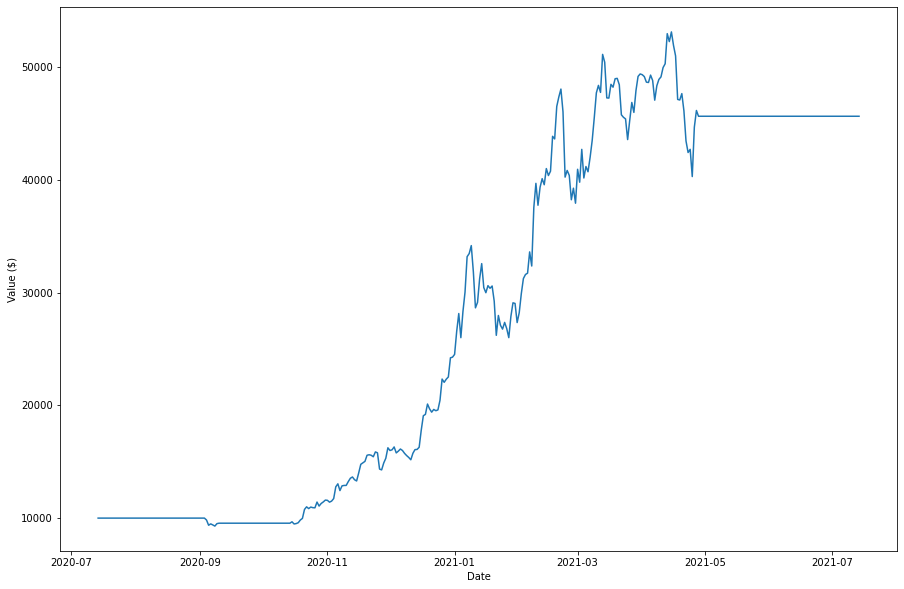

In [10]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(result.Date, result['Portfolio Value'])
ax.set_ylabel("Value ($)")
ax.set_xlabel("Date");